<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week3/tanh_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron with continuous activation function and the gradient descent training algorithm

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

class Perceptron:
    def __init__(self, input_dim, activation_function='linear', init_method='zero'):
        # weight initialization:
        if init_method == 'random':
            self.weights = np.random.uniform(-1, 1, (input_dim, 1)) / 10  # Random initialization
            self.bias = float(np.random.uniform(-1, 1) / 10)
        elif init_method == 'widrow-hoff':
            self.weights = np.random.randn(input_dim, 1) * (2 / np.sqrt(input_dim))  # Widrow-Hoff rule
            self.bias = float(np.random.randn() * (2 / np.sqrt(input_dim)))
        else: # init_method == 'zero':
            self.weights = np.zeros((input_dim, 1))  # Initialize weights to zeros
            self.bias = 0.0
        self.activation_function = activation_function
        self.epochs = -1

    def set_weights(self, weights, bias):
        self.weights = np.array(weights, dtype=float).reshape(-1, 1)
        self.bias = float(bias)

    def __str__(self):
        return f"Perceptron(weights={self.weights.T}, bias={self.bias})"

    def activation(self, x):
        if self.activation_function == 'linear':
            return x
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        else:
            raise ValueError("Unknown activation function")

    def forward(self, inputs):
        potential = np.dot(inputs, self.weights) + self.bias
        #potential = inputs @ self.weights + self.bias
        return self.activation(potential).flatten()

    def gradient_descent_iterative(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent iterative:")
        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs, self.forward(validation_inputs))

        for epoch in range(epochs):

            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(len(training_inputs))
            training_inputs = training_inputs[shuffled_indices]
            true_outputs = true_outputs[shuffled_indices]

            for inputs, true_output in zip(training_inputs, true_outputs):
                prediction = self.forward(inputs) # (1,)
                error = true_output - prediction.reshape(-1, 1) # (1, 1)

                # derivative of the activation function:
                if self.activation_function == 'linear':
                    grad = error  # (1, 1)
                elif self.activation_function == 'tanh':
                    grad = error * (1 - prediction ** 2)  # (1, 1), tanh derivative
                elif self.activation_function == 'sigmoid':
                    grad = error * prediction * (1 - prediction)  # (1, 1), sigmoid derivative
                else:
                    raise ValueError("Unknown activation function")

                self.weights += learning_rate * grad * inputs.reshape(-1, 1)  # (n, 1)
                self.bias += float((learning_rate * error).item())   # Scalar
            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs, self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse

            mse = MSE_error(true_outputs, self.forward(training_inputs))
            training_errors.append(mse)
            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)
        self.epochs = epoch+1
        return training_errors, validation_errors


    def gradient_descent_batch(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent batch:")

        training_inputs = np.array(training_inputs)  # (m, n)
        true_outputs = np.array(true_outputs).reshape(-1, 1)  # (m, 1)
        batch_size = training_inputs.shape[0]  # Scalar

        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs, self.forward(validation_inputs))

        for epoch in range(epochs):
            prediction = self.forward(training_inputs).reshape(-1, 1)  # (m, 1)
            error = true_outputs - prediction  # (m, 1)

            if self.activation_function == 'linear':
                grad = error  # (m, 1)
            elif self.activation_function == 'tanh':
                grad = error * (1 - prediction ** 2)  # (m, 1), tanh derivative
            elif self.activation_function == 'sigmoid':
                grad = error * prediction * (1 - prediction)  # (m, 1), sigmoid derivative
            else:
                raise ValueError("Unknown activation function")

            weight_gradient = (training_inputs.T @ grad) / batch_size  # (n, 1)
            bias_gradient = np.mean(grad)  # Scalar

            self.weights += learning_rate * weight_gradient  # (n, 1)
            self.bias += learning_rate * bias_gradient  # Scalar


            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs, self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse
            mse = MSE_error(true_outputs.flatten(), self.forward(training_inputs))  # (m,)
            training_errors.append(mse)

            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)

        self.epochs = epoch + 1
        return training_errors, validation_errors

def sign(x):
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

def perceptron_error(true_outputs, predicted_outputs):
    return np.sum(true_outputs != np.round(predicted_outputs))

def SSE_error(true_outputs, predicted_outputs):
    # The Sum squared error
    return np.sum((true_outputs - predicted_outputs) ** 2)
def SAE_error(true_outputs, predicted_outputs):
    # The Sum absolute error
    return np.sum(np.abs(true_outputs - predicted_outputs))
def MAE_error(true_outputs, predicted_outputs):
    # The Mean absolute error
    return np.mean(np.abs(true_outputs - predicted_outputs))
def MSE_error(true_outputs, predicted_outputs):
    # The Mean squared error
    return np.mean((true_outputs - predicted_outputs) ** 2)


### Axiliary functions:


In [31]:

def plot_regression_3D(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression plane in 3D."""

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], true_outputs.flatten(),
               label="Data points", color='blue', alpha=0.4, s=50)

    # Create a meshgrid for the plane
    x_range = np.linspace(min(training_inputs[:, 0]), max(training_inputs[:, 0]), 20)
    y_range = np.linspace(min(training_inputs[:, 1]), max(training_inputs[:, 1]), 20)
    X, Y = np.meshgrid(x_range, y_range)

    # Calculate Z values for the plane using the perceptron's weights and bias
    Z = perceptron.weights[0] * X + perceptron.weights[1] * Y + perceptron.bias

    # Plot the regression plane
    ax.plot_surface(X, Y, Z, alpha=0.5, facecolors=plt.cm.Reds(Z), edgecolor='k', rstride=1, cstride=1)

    # Labels
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.set_zlabel("y")
    ax.set_title("3D Linear Regression Fit")

    plt.show()
def plot_decision_boundary_3D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron in 3D."""
    # Select first three columns if more than three exist
    training_inputs = training_inputs[:, :3]

    # Check if the input data has 3 features
    if training_inputs.shape[1] != 3:
        raise ValueError("Input data must have at least 3 features for 3D visualization.")

    # Create a meshgrid of points
    x_min, x_max = training_inputs[:, 0].min() - 1, training_inputs[:, 0].max() + 1
    y_min, y_max = training_inputs[:, 1].min() - 1, training_inputs[:, 1].max() + 1
    z_min, z_max = training_inputs[:, 2].min() - 1, training_inputs[:, 2].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                          np.arange(y_min, y_max, 0.1))

    # Calculate z values for the decision boundary
    zz = (-perceptron.weights[0] * xx - perceptron.weights[1] * yy - perceptron.bias) / perceptron.weights[2]

    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the decision boundary
    ax.plot_surface(xx, yy, zz, alpha=0.5)

    # Plot the training data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], training_inputs[:, 2], c=true_outputs, cmap=plt.cm.Paired)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    ax.set_title('Perceptron Decision Boundary (3D)')

    plt.show()
def plot_decision_boundary_2D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract the first two columns of training_inputs
    x1 = training_inputs[:, 0]
    x2 = training_inputs[:, 1]

    # Generate points for visualization
    x_min, x_max = np.min(x1) - 1, np.max(x1) + 1  # Extend the range slightly
    y_min, y_max = np.min(x2) - 1, np.max(x2) + 1  # Extend the range slightly

    x = np.linspace(x_min, x_max, 100)
    weights = perceptron.weights.flatten()
    y = -(weights[0] * x + perceptron.bias) / weights[1]

    plt.figure(figsize=(5, 3))
    # Plot the decision boundary
    plt.plot(x, y, label='Decision Boundary')

    # Plot the points
    for i, input_vector in enumerate(training_inputs):
        if true_outputs[i] == 1:
            plt.scatter(input_vector[0], input_vector[1], color='green', label='Class 1' if i == 0 else "")  # Add label only for the first point of each class
        else:
            plt.scatter(input_vector[0], input_vector[1], color='red', label='Class -1' if i == 0 else "")

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title('Perceptron Decision Boundary', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)  # Set y-axis limits

    # Highlight x and y axes
    plt.axhline(0, color='black', linewidth=0.8)  # x-axis
    plt.axvline(0, color='black', linewidth=0.8)  # y-axis
    plt.show()

def plot_regression(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression line."""
    plt.figure(figsize=(4, 3))

    # Plot the data points
    plt.scatter(training_inputs, true_outputs, label="Data points", color='blue', alpha=0.6)

    # Generate predictions for the regression line
    X_test = np.linspace(-1, 1, 100).reshape(-1, 1)
    d_pred = perceptron.weights * X_test + perceptron.bias

    plt.plot(X_test, d_pred, label="Regression line", color='red', linewidth=2)
    plt.xlabel("x_1")
    plt.ylabel("y")
    plt.legend()
    plt.title("Linear Regression Fit")
    plt.show()

def plot_error_progress(train_errors, validation_errors):
    fig = plt.figure(figsize=(4, 3))
    plt.plot(validation_errors, label='Validation Error')
    plt.plot(train_errors, label='Train Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Validation and Train Error Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


### Run tests

In [32]:

def run_example_multiple_times(experiment_results, training_data, testing_data, validation_data, activation, epochs, init_method, learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=10, num_runs=10):
    inputs, true_outputs = training_data
    if testing_data is None:
        testing_data = training_data
    max_validation_steps = None if validation_data is None else max_validation_steps
    test_inputs, test_true_outputs = testing_data
    times = []
    mse_errors = []
    mae_errors = []
    mse_test_errors = []
    mae_test_errors = []
    epoch_counts = []

    for _ in range(num_runs):

        start_time = time.time()
        neuron = Perceptron(inputs.shape[1], activation, init_method)

        if variant == 'iterative':
            neuron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress)
        else:
            neuron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress, print_progress=print_progress)

        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = neuron.forward(inputs)
        mse = MSE_error(true_outputs, real_outputs)
        mae = MAE_error(true_outputs, real_outputs)

        real_outputs = neuron.forward(test_inputs)
        mse_test = MSE_error(test_true_outputs, real_outputs)
        mae_test = MAE_error(test_true_outputs, real_outputs)

        times.append(elapsed_time)
        mse_errors.append(mse)
        mae_errors.append(mae)
        mse_test_errors.append(mse_test)
        mae_test_errors.append(mae_test)
        epoch_counts.append(neuron.epochs)

    avg_time = np.mean(times)
    avg_mse = np.mean(mse_errors)
    avg_mae = np.mean(mae_errors)
    avg_test_mse = np.mean(mse_test_errors)
    avg_test_mae = np.mean(mae_test_errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'MSE': avg_mse,
        'MAE': avg_mae,
        'Test MSE': avg_test_mse,
        'Test MAE': avg_test_mae,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': neuron.weights,  # Note: Weights and bias are from the last run.
        'Bias': neuron.bias,
        'Data Description': data_description
    } #experiment_results_r = pd.DataFrame(columns=['MSE', 'SSE', 'Test MSE' 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

    experiment_results.loc[len(experiment_results)] = results

## Example 1:  Gallbladder Attack
- We predict whether a patient will have a gallbladder attack, depending on whether they ate a salad, pork belly, and whether they took medication.

In [34]:
def example_gallblader_attack():
    # Egg Salad, Pork Belly, Medicines -> Gallbladder Attack
    inputs = np.array([
        [+1, -1, -1],
        [+1, -1, +1],
        [-1, +1, -1],
        [-1, +1, +1],
        [+1, +1, -1],
        [+1, +1, +1]
    ])

    true_outputs = np.array([
        +1,
        -1,
        +1,
        -1,
        +1,
        +1
    ])
    return inputs, true_outputs

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs

Gradient Descent iterative:
Epoch: 0, MSE: 0.3001 Weights: [[ 0.81510352  0.34431138 -0.82698771]] Bias: 0.5858399105125245 Learning rate: 0.5000
Epoch: 1, MSE: 0.2695 Weights: [[ 0.36634978  0.9152725  -1.70494652]] Bias: 0.17853135037093548 Learning rate: 0.5000
Epoch: 2, MSE: 0.0273 Weights: [[ 1.43653066  1.01115757 -1.80010871]] Bias: 0.10670645292369563 Learning rate: 0.5000
Epoch: 3, MSE: 0.0131 Weights: [[ 1.55171553  1.17688743 -1.6875566 ]] Bias: 0.28788500221932056 Learning rate: 0.5000
Epoch: 4, MSE: 0.0096 Weights: [[ 1.53496621  1.255721   -1.71000149]] Bias: 0.28740138810039406 Learning rate: 0.5000
Epoch: 5, MSE: 0.0080 Weights: [[ 1.52871098  1.30519579 -1.72532841]] Bias: 0.2893635996068612 Learning rate: 0.5000
Epoch: 6, MSE: 0.0067 Weights: [[ 1.51438478  1.34449067 -1.75275202]] Bias: 0.2527229676420077 Learning rate: 0.5000
Epoch: 7, MSE: 0.0061 Weights: [[ 1.52000593  1.37613147 -1.75935161]] Bias: 0.25621313165009274 Learning rate: 0.5000
Epoch: 8, MSE: 0.0056 W

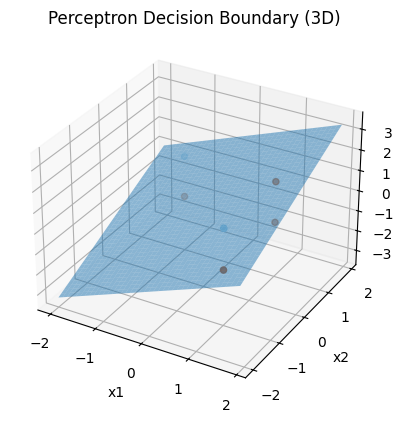

,Input,Predicted,True
0,"[1, -1, -1]",[0.9699705275667927],1
1,"[1, -1, 1]",[-0.9123633180881674],-1
2,"[-1, 1, -1]",[0.9646662290211581],1
3,"[-1, 1, 1]",[-0.9252204659061246],-1
4,"[1, 1, -1]",[0.9999285167889761],1
5,"[1, 1, 1]",[0.9026480734337566],1


In [35]:
# Data and parameters:
inputs, true_outputs = example_gallblader_attack()
data_description = "Gallbladder Attack"

print_progress = True
activation = 'tanh'
learning_rate = 0.5
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_3D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [36]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

inputs, true_outputs = example_gallblader_attack()
data_description_orig = "Gallbladder Attack"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.097652,0.268563,100.0,0.016013,iterative,0.01,100,"[[0.6485169182949149], [0.6490690683044507], [...",0.245462,Gallbladder Attack non-adaptive 0.0001
1,0.007072,0.072188,100.0,0.018030,iterative,0.10,100,"[[1.40421594997015], [1.403061384456241], [-1....",0.207599,Gallbladder Attack non-adaptive 0.0001
2,0.000199,0.009793,74.4,0.012272,iterative,1.00,100,"[[2.317655866703356], [3.2376279929461527], [-...",0.724707,Gallbladder Attack non-adaptive 0.0001
3,0.316014,0.514444,2.0,0.000333,iterative,0.10,2,"[[0.27814390895752966], [0.2764047479162208], ...",0.257132,Gallbladder Attack non-adaptive 0.0001
4,0.159763,0.348636,5.0,0.000795,iterative,0.10,5,"[[0.5199308288511721], [0.46467555720774595], ...",0.242748,Gallbladder Attack non-adaptive 0.0001
5,0.081273,0.245678,10.0,0.001778,iterative,0.10,10,"[[0.7155112556567941], [0.7170493362824536], [...",0.248302,Gallbladder Attack non-adaptive 0.0001
6,0.039119,0.169552,20.0,0.003091,iterative,0.10,20,"[[0.9179010287707083], [0.9253290818943241], [...",0.225984,Gallbladder Attack non-adaptive 0.0001
7,0.357481,0.557510,100.0,0.015505,iterative,0.01,100,"[[0.21342418035733454], [0.2349537526062464], ...",0.205618,Gallbladder Attack adaptive 0.0001
8,0.045113,0.181566,100.0,0.016573,iterative,0.10,100,"[[0.8849310071117351], [0.8849816694269361], [...",0.240601,Gallbladder Attack adaptive 0.0001
9,0.001398,0.026567,92.5,0.016989,iterative,1.00,100,"[[1.731326871793244], [1.7179583330199653], [-...",0.263127,Gallbladder Attack adaptive 0.0001


## Example 2:  Pub
- We predict whether the friends (Pavel, Pepa, Honza) will go to a pub depending on who of them has currently time.

In [37]:
def example_pub():
    # Pavel, Pepa, Honza -> Go to a pub?
    inputs = np.array([
        [ +1, -1, -1],
        [ +1, -1, +1],
        [ -1, +1, -1],
        [ -1, +1, +1],
        [ +1, +1, -1],
        [ +1, +1, +1],
        [ -1, -1, -1],
        [ -1, -1, +1]
    ])

    true_outputs = np.array([-1, +1, -1, +1, +1, +1, -1, -1])
    return inputs, true_outputs

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs

Gradient Descent iterative:
Epoch: 0, MSE: 0.2523 Weights: [[0.4319115  0.80978116 0.57720633]] Bias: -0.22496475708706998 Learning rate: 0.5000
Epoch: 1, MSE: 0.1121 Weights: [[1.13102718 1.58775442 1.15793293]] Bias: -0.5753061922566381 Learning rate: 0.5000
Epoch: 2, MSE: 0.0116 Weights: [[1.59231517 1.26070892 1.57370608]] Bias: -0.02851596957362651 Learning rate: 0.5000
Epoch: 3, MSE: 0.0087 Weights: [[1.5979105  1.34632884 1.57836286]] Bias: -0.02095846502764631 Learning rate: 0.5000
Epoch: 4, MSE: 0.0072 Weights: [[1.59853012 1.4055476  1.59057104]] Bias: 0.007474618085187179 Learning rate: 0.5000
Epoch: 5, MSE: 0.0063 Weights: [[1.60557886 1.45162007 1.59781219]] Bias: -0.018831239963203128 Learning rate: 0.5000
Epoch: 6, MSE: 0.0056 Weights: [[1.61436362 1.49259133 1.60174286]] Bias: 0.018406978443464672 Learning rate: 0.5000
Epoch: 7, MSE: 0.0051 Weights: [[1.62380923 1.52191226 1.60960816]] Bias: 0.0005793928007674087 Learning rate: 0.5000
Epoch: 8, MSE: 0.0048 Weights: [[1.

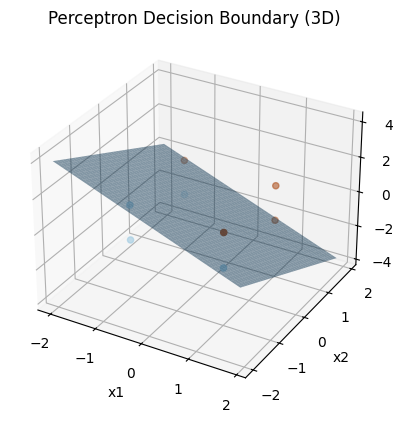

,Input,Predicted,True
0,"[1, -1, -1]",[-0.9295101244907368],-1
1,"[1, -1, 1]",[0.9350473003455856],1
2,"[-1, 1, -1]",[-0.9387932522979575],-1
3,"[-1, 1, 1]",[0.9252179441767416],1
4,"[1, 1, -1]",[0.9276107881721626],1
5,"[1, 1, 1]",[0.9999079020848154],1
6,"[-1, -1, -1]",[-0.9999133809987941],-1
7,"[-1, -1, 1]",[-0.9317704964405026],-1


In [54]:
# Data and parameters:
inputs, true_outputs = example_pub()
data_description = "Pub"

print_progress = True
activation = 'tanh'
learning_rate = 0.5
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_3D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [39]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

inputs, true_outputs = example_gallblader_attack()
data_description_orig = "Gallbladder Attack"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.098477,0.269866,100.0,0.019049,iterative,0.01,100,"[[0.6544687338597707], [0.654574431057802], [-...",0.245576,Gallbladder Attack non-adaptive 0.0001
1,0.007069,0.072176,100.0,0.021074,iterative,0.10,100,"[[1.4041887420925072], [1.4033899402010814], [...",0.205501,Gallbladder Attack non-adaptive 0.0001
2,0.000211,0.010245,84.3,0.015467,iterative,1.00,100,"[[2.163652406252673], [2.158266663837009], [-2...",0.338717,Gallbladder Attack non-adaptive 0.0001
3,0.320645,0.515322,2.0,0.000334,iterative,0.10,2,"[[0.25495558906506294], [0.23257210455889904],...",0.190174,Gallbladder Attack non-adaptive 0.0001
4,0.158091,0.346233,5.0,0.000771,iterative,0.10,5,"[[0.5237704915406288], [0.5309436945284277], [...",0.268705,Gallbladder Attack non-adaptive 0.0001
5,0.080351,0.244440,10.0,0.001862,iterative,0.10,10,"[[0.7153116223662044], [0.7202371037645414], [...",0.225485,Gallbladder Attack non-adaptive 0.0001
6,0.038776,0.169203,20.0,0.003076,iterative,0.10,20,"[[0.9303846935577421], [0.9297479198421729], [...",0.232790,Gallbladder Attack non-adaptive 0.0001
7,0.362589,0.561970,100.0,0.017567,iterative,0.01,100,"[[0.19872978668813526], [0.18955457658826405],...",0.219568,Gallbladder Attack adaptive 0.0001
8,0.045268,0.181737,100.0,0.020640,iterative,0.10,100,"[[0.8811190915722421], [0.880975474953723], [-...",0.243285,Gallbladder Attack adaptive 0.0001
9,0.001062,0.023539,100.0,0.016617,iterative,1.00,100,"[[2.227649322435362], [2.2090830888682675], [-...",0.895538,Gallbladder Attack adaptive 0.0001


## Example 3 - Linear regression with two input dimensions


In [40]:
def generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.3, number_of_samples=100):
    # y = A x1 + B x2 + C + noise

    # Generate x1 and x2 from a uniform distribution (more variation than linspace)
    x1 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = x2[np.random.permutation(number_of_samples)]  # Randomly shuffle x2
    inputs = np.hstack([x1, x2])

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=x1.shape)  # Gaussian noise
    true_outputs = A*x1 + B*x2 + C + noise
    return inputs, normalize_outputs(true_outputs)
def normalize_outputs(outputs):
    min_val = np.min(outputs)
    max_val = np.max(outputs)

    # Normalize to the range [0, 1]
    normalized_outputs = (outputs - min_val) / (max_val - min_val)

    # Scale to the range [-1, 1]
    normalized_outputs = 2 * normalized_outputs - 1

    return normalized_outputs


- observe, that the regression task is very difficult for a perceptron with tanh activation function and that it is very sensitive to the choice of initial learning rate:

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.2436, Validation MSE: 0.2105 Weights: [[ 0.09333458 -0.02372956]] Bias: 0.08844272002317366 Learning rate: 0.0001
Epoch: 1, Training MSE: 0.2433, Validation MSE: 0.2104 Weights: [[ 0.0944667  -0.02142183]] Bias: 0.08720676134805452 Learning rate: 0.0001
Epoch: 2, Training MSE: 0.2430, Validation MSE: 0.2104 Weights: [[ 0.09526501 -0.01979457]] Bias: 0.08634053128590147 Learning rate: 0.0001
Epoch: 3, Training MSE: 0.2429, Validation MSE: 0.2104 Weights: [[ 0.09591542 -0.01846876]] Bias: 0.08563778689972493 Learning rate: 0.0001
Epoch: 4, Training MSE: 0.2427, Validation MSE: 0.2104 Weights: [[ 0.09647772 -0.0173225 ]] Bias: 0.08503357755262371 Learning rate: 0.0000
Epoch: 5, Training MSE: 0.2426, Validation MSE: 0.2103 Weights: [[ 0.09697981 -0.01629887]] Bias: 0.08449556317964373 Learning rate: 0.0000
Epoch: 6, Training MSE: 0.2425, Validation MSE: 0.2103 Weights: [[ 0.09743748 -0.01536574]] Bias: 0.0840067334759654 Learning rate: 

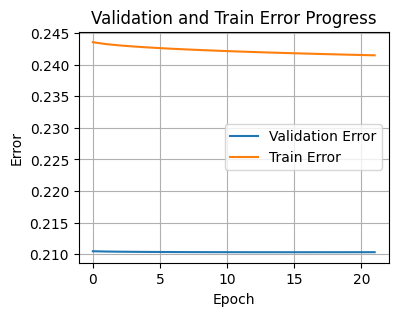

Train Perceptron error: 10000, Test PE: 10000
Train MAE error: 0.4147428784474703, Test MAE: 0.4608045168859674
Train MSE error: 0.24148328229718846, Test MSE: 0.2891481792781736


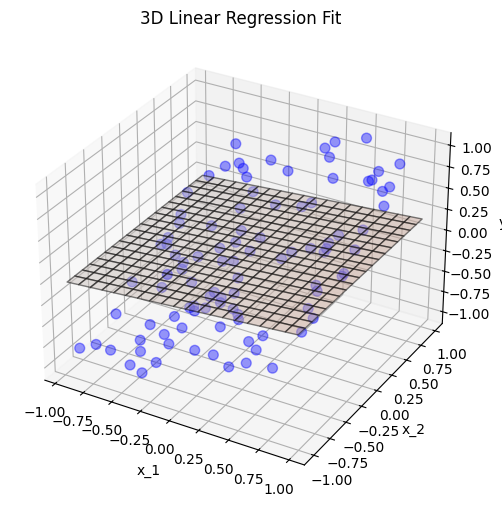

,Input,Predicted,True
0,"[0.8819374609802009, 0.7727694860545671]",[0.163134584127629],[0.9142475088722988]
1,"[-0.6700948352812894, 0.15278168991246988]",[0.00983010857769772],[0.026113952377617267]
2,"[-0.017397273681805547, -0.34263437110203765]",[0.07921302155268535],[-0.2679561811076948]
3,"[-0.36469645587306565, -0.1876257896358795]",[0.042986439764035975],[-0.333392832891484]
4,"[0.6865050632946219, 0.018134357608877494]",[0.1480106981709435],[0.4124443201584196]
...,...,...,...
95,"[-0.5685389878612415, -0.2876057464581201]",[0.022790409752760938],[-0.4101781074323103]
96,"[0.47632431998116487, 0.13724138763645222]",[0.12627073832743502],[0.1857167605140413]
97,"[0.021418234338893116, -0.42096674495571595]",[0.08360792715897249],[-0.2563408396315541]
98,"[-0.21456862419978218, -0.47250714621780143]",[0.05994605875496207],[-0.3785544321060308]


In [41]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
validation_data = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)

# Train the perceptron:
activation = 'tanh'
print_progress = True
learning_rate = 0.0001
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 100
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)

# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df

## Example 4:  Randomly Generated Clustered Data


In [42]:
def example_random_clusters():
    """ Generate two separable clusters """
    N=40
    spread=2.0
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.5076, Validation MSE: 0.6501 Weights: [[0.00929917 0.13631524]] Bias: -0.07465494870496062 Learning rate: 0.0010
Epoch: 1, Training MSE: 0.3529, Validation MSE: 0.5322 Weights: [[0.05167872 0.17245386]] Bias: -0.07278146670131336 Learning rate: 0.0007
Epoch: 2, Training MSE: 0.2973, Validation MSE: 0.4891 Weights: [[0.07278409 0.19091044]] Bias: -0.07162003796292758 Learning rate: 0.0006
Epoch: 3, Training MSE: 0.2667, Validation MSE: 0.4652 Weights: [[0.08657651 0.20360444]] Bias: -0.07083702906954424 Learning rate: 0.0005
Epoch: 4, Training MSE: 0.2464, Validation MSE: 0.4493 Weights: [[0.09684486 0.21346505]] Bias: -0.07018182483175202 Learning rate: 0.0004
Epoch: 5, Training MSE: 0.2318, Validation MSE: 0.4380 Weights: [[0.10493681 0.22154312]] Bias: -0.06966606176018607 Learning rate: 0.0004
Epoch: 6, Training MSE: 0.2205, Validation MSE: 0.4293 Weights: [[0.11160217 0.22840766]] Bias: -0.06921027772091505 Learning rate: 0.0004

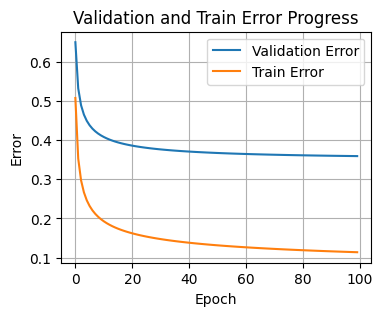

Train Perceptron error: 6, Test PE: 8
Train MAE error: 0.23559364923573858, Test MAE: 0.3797215363506431
Train MSE error: 0.11365849427279225, Test MSE: 0.357002509797181


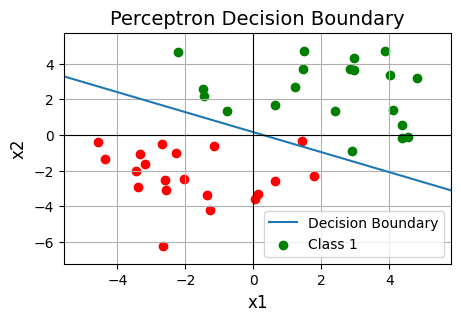

In [43]:
# Data and parameters:
np.random.seed(642)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.001
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 100
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
#df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [44]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description_orig = "clusters"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
max_validation_steps = None

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)
learning_rate = 0.1
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.178196,0.195403,100.0,0.082120,iterative,0.01,100,"[[0.8508086720971061], [0.4173105338145557]]",0.206796,clusters non-adaptive 0.0001
1,0.184293,0.177048,100.0,0.088551,iterative,0.10,100,"[[1.027154653108437], [0.5530609017620339]]",0.325462,clusters non-adaptive 0.0001
2,0.262879,0.144501,100.0,0.105608,iterative,1.00,100,"[[9.6578175816346], [4.915308036196393]]",2.541913,clusters non-adaptive 0.0001
3,0.188529,0.225403,1.0,0.001653,iterative,0.10,1,"[[0.7538858176554957], [0.3806842179225574]]",0.065822,clusters non-adaptive 0.0001
4,0.183856,0.209295,2.0,0.002761,iterative,0.10,2,"[[0.8113798084152636], [0.38055148358343704]]",0.044959,clusters non-adaptive 0.0001
5,0.180963,0.188086,5.0,0.007366,iterative,0.10,5,"[[0.977534625212443], [0.3934476317717685]]",0.142101,clusters non-adaptive 0.0001
6,0.181689,0.182732,10.0,0.013310,iterative,0.10,10,"[[1.0181951364539186], [0.3989867354214571]]",0.277411,clusters non-adaptive 0.0001
7,0.184062,0.176741,20.0,0.027166,iterative,0.10,20,"[[1.0431657864583954], [0.47165786830646994]]",0.223262,clusters non-adaptive 0.0001


## Example 4a:  Randomly Generated Clustered Data And Normalization


- the input data are shifted:

In [45]:
def example_shifted_clusters():
    """ Generate two separable clusters """
    N=40
    spread=2.0
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])+500
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])+500
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs

def normalize_data(data):
    """Normalizes data to the range [-1, 1]."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero if min and max are the same
    max_vals = np.where(max_vals == min_vals, max_vals + 1e-6, max_vals)

    normalized_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return normalized_data

def example_normalized_clusters():
    inputs, true_outputs = example_shifted_clusters()
    return normalize_data(inputs), true_outputs

- Set the parameters, run the experiment and observe the results:
- Observe, that it is very difficult for the perceptron to learn the task, if the input data is not normalized
- Normalize the data and run the experiment again

Gradient Descent iterative:
Epoch: 0, Training MSE: 2.0000, Validation MSE: 2.0000 Weights: [[-0.05883797  0.07537199]] Bias: -0.0966345668761365 Learning rate: 0.0005
Epoch: 1, Training MSE: 2.0000, Validation MSE: 2.0000 Weights: [[-0.05884188  0.0753681 ]] Bias: -0.11663456332598059 Learning rate: 0.0004
Epoch: 2, Training MSE: 2.0000, Validation MSE: 2.0000 Weights: [[-0.05884475  0.07536523]] Bias: -0.13077669634314742 Learning rate: 0.0003
Epoch: 3, Training MSE: 2.0000, Validation MSE: 2.0000 Weights: [[-0.05884718  0.07536281]] Bias: -0.14232369952790871 Learning rate: 0.0003
Epoch: 4, Training MSE: 2.0000, Validation MSE: 2.0000 Weights: [[-0.05884933  0.07536066]] Bias: -0.15232369757527134 Learning rate: 0.0002
Epoch: 5, Training MSE: 2.0000, Validation MSE: 2.0000 Weights: [[-0.0588513  0.0753587]] Bias: -0.16126796769590607 Learning rate: 0.0002
Epoch: 6, Training MSE: 2.0000, Validation MSE: 2.0000 Weights: [[-0.05885313  0.07535687]] Bias: -0.16943293183823252 Learning r

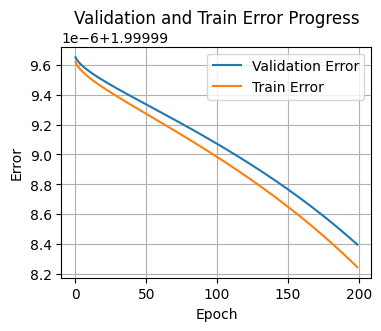

Train Perceptron error: 20, Test PE: 20
Train MAE error: 0.9999999182373337, Test MAE: 0.9999999528351615
Train MSE error: 1.999998244123247, Test MSE: 1.99999837742805


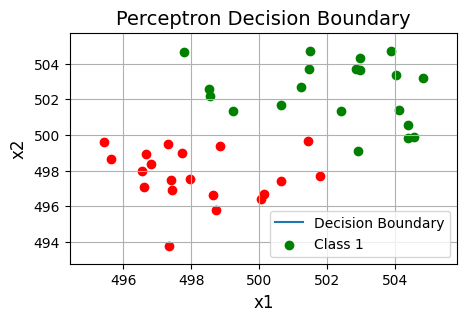

,Input,Predicted,True
0,"[498.5072717037158, 502.55835546726917]",[0.9999995797475152],1.0
1,"[504.0145407926594, 503.35730013198133]",[0.9999992856584627],1.0
2,"[504.3854188174532, 499.82065238077416]",[0.9999987300966698],1.0
3,"[500.64789099468214, 501.679817566812]",[0.9999993824472185],1.0
4,"[504.0993940230951, 501.3805209317769]",[0.9999990288556684],1.0
5,"[499.2383771598388, 501.3649525294433]",[0.999999451833864],1.0
6,"[502.40607833134186, 501.3327193478532]",[0.9999991991879722],1.0
7,"[497.7924515736284, 504.68013048988416]",[0.999999719231164],1.0
8,"[502.9163893252042, 499.11467338600744]",[0.9999988129104597],1.0
9,"[504.56302132735885, 499.89578571177276]",[0.9999987177333404],1.0


In [53]:
def example_random_clusters():
  return example_shifted_clusters()
  # return example_normalized_clusters()

# Data and parameters:
np.random.seed(642)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.0005
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 200
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- normalize the data and run the experiment again:

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.2568, Validation MSE: 0.4286 Weights: [[0.65662707 0.9303197 ]] Bias: -0.12984552967000096 Learning rate: 0.1000
Epoch: 1, Training MSE: 0.1815, Validation MSE: 0.3804 Weights: [[0.86773653 1.27346747]] Bias: -0.1542570797397904 Learning rate: 0.0707
Epoch: 2, Training MSE: 0.1586, Validation MSE: 0.3753 Weights: [[0.92196469 1.44905503]] Bias: -0.2124073770585808 Learning rate: 0.0577
Epoch: 3, Training MSE: 0.1450, Validation MSE: 0.3698 Weights: [[0.95731165 1.57143896]] Bias: -0.20203452346311182 Learning rate: 0.0500
Epoch: 4, Training MSE: 0.1363, Validation MSE: 0.3675 Weights: [[0.98583237 1.66232518]] Bias: -0.20965625482448946 Learning rate: 0.0447
Epoch: 5, Training MSE: 0.1299, Validation MSE: 0.3679 Weights: [[1.00238908 1.73692368]] Bias: -0.23177344434500752 Learning rate: 0.0408
Epoch: 6, Training MSE: 0.1251, Validation MSE: 0.3680 Weights: [[1.01993879 1.79773404]] Bias: -0.24846158210974087 Learning rate: 0.0378
E

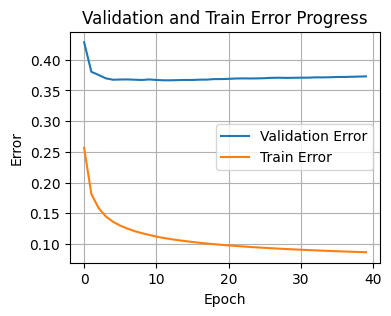

Train Perceptron error: 3, Test PE: 11
Train MAE error: 0.1770311857723179, Test MAE: 0.37490527244386873
Train MSE error: 0.08675288281647767, Test MSE: 0.4610599665791589


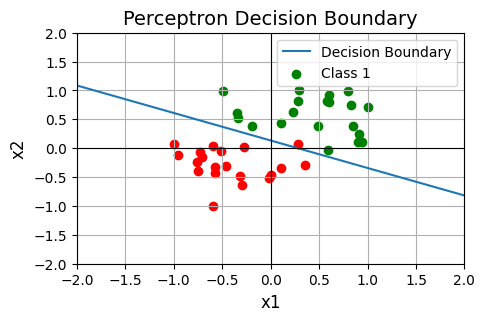

,Input,Predicted,True
0,"[-0.343649568119454, 0.6019865918489369]",[0.644858260767074],1.0
1,"[0.8270957930544727, 0.7478150561703909]",[0.9875991171126635],1.0
2,"[0.9059377236150226, 0.10228360301240436]",[0.7644154865727887],1.0
3,"[0.11140720583945352, 0.44163026364438207]",[0.7203734954665629],1.0
4,"[0.8451340483691963, 0.3870007372309723]",[0.9290076362491319],1.0
5,"[-0.1882298296862308, 0.3841590933668566]",[0.38348391884420874],1.0
6,"[0.48516589371645136, 0.3782756879458109]",[0.8328091946707098],1.0
7,"[-0.49560734208289836, 0.9892664709817871]",[0.9153900130049183],1.0
8,"[0.5936487405088506, -0.026576175639631994]",[0.2981060634290337],1.0
9,"[0.943692790826518, 0.11599741670040009]",[0.7956335606310091],1.0


In [50]:
def example_random_clusters():
  #return example_shifted_clusters() # comment this row to normalize the data
  return example_normalized_clusters()

# Data and parameters:
np.random.seed(642)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.1
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 200
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


## Example 6  - Outliers

In [98]:
def example_outliers():
    # data with outliers
    inputs = np.array([
        [-0.5, -0.5],
        [ 0.3, -0.5],
        [ -40,   50], # outlier
        [ -0.8, 1],
        [ -0.1, 1.0]
    ])

    true_outputs = np.array([1, 1, -1, -1, 1])
    return inputs, true_outputs

def normalize_data(data):
    """Normalizes data to the range [-1, 1]."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero if min and max are the same
    max_vals = np.where(max_vals == min_vals, max_vals + 1e-6, max_vals)

    normalized_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return normalized_data
def example_normalized_outliers():
    inputs, true_outputs = example_outliers()
    return normalize_data(inputs), true_outputs

def normalize_data_std(data):
    """Normalizes data using standard deviation."""
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)

    # Avoid division by zero if standard deviation is zero
    std_vals = np.where(std_vals == 0, 1e-6, std_vals)  # Add a small value to avoid division by zero

    normalized_data = (data - mean_vals) / std_vals
    return normalized_data

def example_std_normalized_outliers():
    inputs, true_outputs = example_outliers()
    return normalize_data_std(inputs), true_outputs

- Set the parameters, run the experiment and observe the results:
- Observe, that the percepron is able to learn the task

Gradient Descent iterative:
Epoch: 0, MSE: 2.0474 Weights: [[ 0.58228517 -0.42740001]] Bias: -1.2834071079703695 Learning rate: 0.8000
Epoch: 1, MSE: 0.7166 Weights: [[ 0.30130864 -0.26614644]] Bias: 1.9332334568117637 Learning rate: 0.5657
Epoch: 2, MSE: 0.5886 Weights: [[ 0.42068847 -0.16720101]] Bias: 1.365002261403553 Learning rate: 0.4619
Epoch: 3, MSE: 0.2727 Weights: [[ 0.68031539 -0.49920084]] Bias: 0.7782196617688412 Learning rate: 0.4000
Epoch: 4, MSE: 0.3351 Weights: [[ 0.75420398 -0.4134946 ]] Bias: 1.2439965737744054 Learning rate: 0.3578
Epoch: 5, MSE: 0.2312 Weights: [[ 1.04136747 -0.46978502]] Bias: 1.2695410013967439 Learning rate: 0.3266
Epoch: 6, MSE: 0.1959 Weights: [[ 1.2379997  -0.49690383]] Bias: 1.3768489753852227 Learning rate: 0.3024
Epoch: 7, MSE: 0.1485 Weights: [[ 1.40056907 -0.59401258]] Bias: 1.4429841741168024 Learning rate: 0.2828
Epoch: 8, MSE: 0.1311 Weights: [[ 1.52177864 -0.6195079 ]] Bias: 1.514014482863859 Learning rate: 0.2667
Epoch: 9, MSE: 0.10

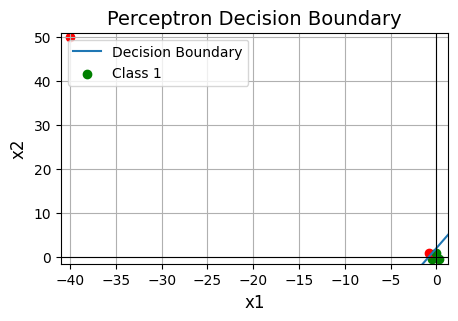

,Input,Predicted,True
0,"[-0.5, -0.5]",[0.8435424448690063],1
1,"[0.3, -0.5]",[0.9945661158636805],1
2,"[-40.0, 50.0]",[-1.0],-1
3,"[-0.8, 1.0]",[-0.6418260596288574],-1
4,"[-0.1, 1.0]",[0.6310938942786092],1


In [91]:
# Data and parameters:
inputs, true_outputs = example_outliers()
data_description = "Out"

print_progress = True
activation = 'tanh'
learning_rate = 0.8
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 20

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- Run the same example with normalization
- In this case, blind normalization leads to worse results.

Gradient Descent iterative:
Epoch: 0, MSE: 0.7705 Weights: [[ 1.91360416 -2.07168728]] Bias: -1.7837042796356148 Learning rate: 2.0000
Epoch: 1, MSE: 2.3217 Weights: [[ 1.72052647 -1.87961932]] Bias: -5.576568234329184 Learning rate: 1.4142
Epoch: 2, MSE: 0.5933 Weights: [[ 1.60950948 -1.76969222]] Bias: -2.4112285856947233 Learning rate: 1.1547
Epoch: 3, MSE: 0.7359 Weights: [[ 1.82016433 -1.96505991]] Bias: -2.0131925300207096 Learning rate: 1.0000
Epoch: 4, MSE: 1.2424 Weights: [[ 1.6352687  -1.78095055]] Bias: -3.7857594043421168 Learning rate: 0.8944
Epoch: 5, MSE: 0.6968 Weights: [[ 2.73509989 -2.91753719]] Bias: -4.041157990014664 Learning rate: 0.8165
Epoch: 6, MSE: 1.0407 Weights: [[ 2.51981531 -2.70345056]] Bias: -5.404075435044972 Learning rate: 0.7559
Epoch: 7, MSE: 0.6720 Weights: [[ 3.47318804 -3.62735486]] Bias: -5.531263753570562 Learning rate: 0.7071
Epoch: 8, MSE: 0.7617 Weights: [[ 3.92636912 -4.05164311]] Bias: -5.682461129812149 Learning rate: 0.6667
Epoch: 9, MSE:

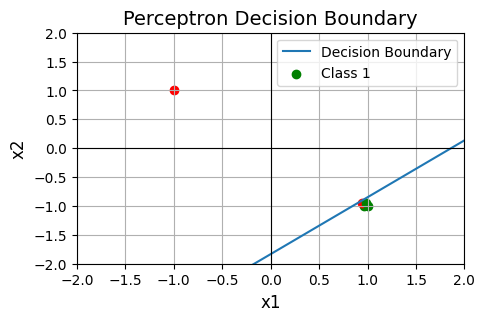

,Input,Predicted,True
0,"[0.9602977667493797, -1.0]",[0.6111863063569023],1
1,"[1.0, -1.0]",[0.7437825606348648],1
2,"[-1.0, 1.0]",[-1.0],-1
3,"[0.9454094292803974, -0.9405940594059405]",[0.23632314133010326],-1
4,"[0.9801488833746899, -0.9405940594059405]",[0.4284086954819032],1


In [102]:
# Data and parameters:
inputs, true_outputs = example_normalized_outliers()
#inputs, true_outputs = example_std_normalized_outliers()
data_description = "Out"

print_progress = True
activation = 'tanh'
learning_rate = 2
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 50

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df